# Capstone Project - The Battle of Neighborhoods (Week 2)

In [49]:
#Importing and intalling all the necessary libraries

In [47]:
!pip install geocoder

In [48]:
!pip install folium

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

Let's define a function for geocodes

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Next we need a function to intract with FourSquare API and get top 100 venues within a defined radius. Below function will return us the venue id , venue name and category

In [5]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'IGOAILKTSGZKIH11WZCYKGYEHZB5JS3UYBZZV2OACXJIENJQ' # your Foursquare ID
    CLIENT_SECRET = 'DUDIJEG0YH4WMDS0OFGFRHUO5M1PN12ZGBQFF3YGKEUA2KMT' # your Foursquare Secret
    VERSION = '20200309' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Using Foursquare credentials, we can get the venue details

In [6]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'IGOAILKTSGZKIH11WZCYKGYEHZB5JS3UYBZZV2OACXJIENJQ' # your Foursquare ID
    CLIENT_SECRET = 'DUDIJEG0YH4WMDS0OFGFRHUO5M1PN12ZGBQFF3YGKEUA2KMT' # your Foursquare Secret
    VERSION = '20200309' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Next step is to get NY data

In [7]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [8]:
new_york_data=get_new_york_data()

In [9]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
new_york_data.shape

(306, 4)

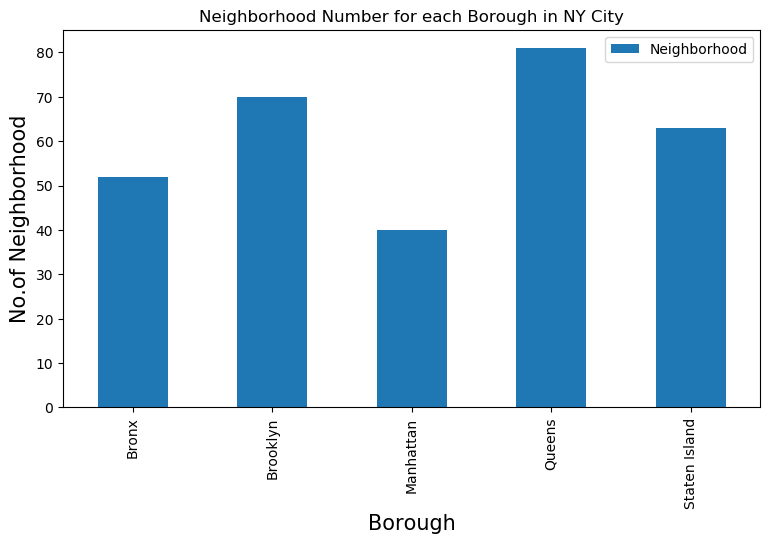

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Neighborhood Number for each Borough in NY City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()



## Getting Russian restaurants for each neighborhood

In [13]:
# we are preparing a neighborhood list with Russian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
ru_restaurants_neighbor=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    ru_restaurants=venues[venues['Category']=='Russian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Russian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(ru_restaurants)))
    for restaurant_detail in ru_restaurants.values.tolist():
        id, name , category=restaurant_detail
        ru_restaurants_neighbor = ru_restaurants_neighbor.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1


( 1 / 306 ) Russian Restaurants in Wakefield, Bronx:0
( 2 / 306 ) Russian Restaurants in Co-op City, Bronx:0
( 3 / 306 ) Russian Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Russian Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Russian Restaurants in Riverdale, Bronx:0
( 6 / 306 ) Russian Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) Russian Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) Russian Restaurants in Woodlawn, Bronx:0
( 9 / 306 ) Russian Restaurants in Norwood, Bronx:0
( 10 / 306 ) Russian Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Russian Restaurants in Baychester, Bronx:0
( 12 / 306 ) Russian Restaurants in Pelham Parkway, Bronx:0
( 13 / 306 ) Russian Restaurants in City Island, Bronx:0
( 14 / 306 ) Russian Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) Russian Restaurants in University Heights, Bronx:0
( 16 / 306 ) Russian Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) Russian Restaurants in Fordham, Bronx:0
( 18 / 306 ) Russian Restaurants in Ea

In [14]:
ru_restaurants_neighbor.shape

(20, 4)

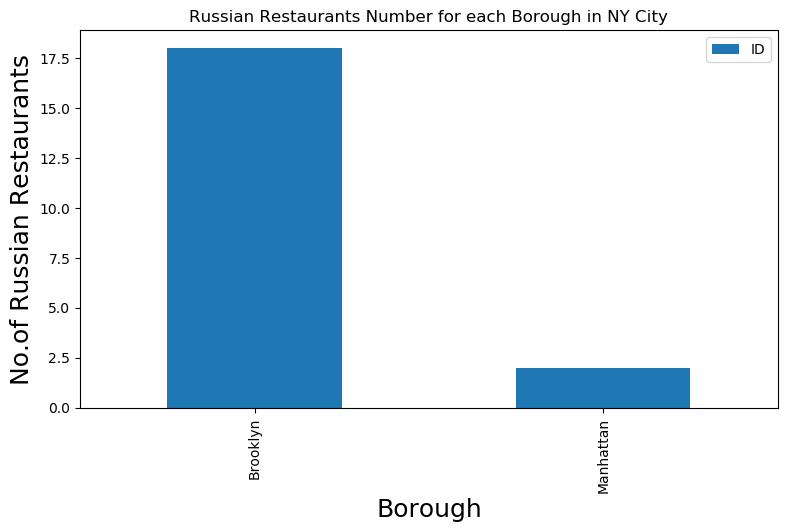

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Russian Restaurants Number for each Borough in NY City')
#On x-axis
plt.xlabel('Borough', fontsize = 18)
#On y-axis
plt.ylabel('No.of Russian Restaurants', fontsize=18)
#giving a bar plot
ru_restaurants_neighbor.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Brooklyn has the highest number of Russian Restaurants

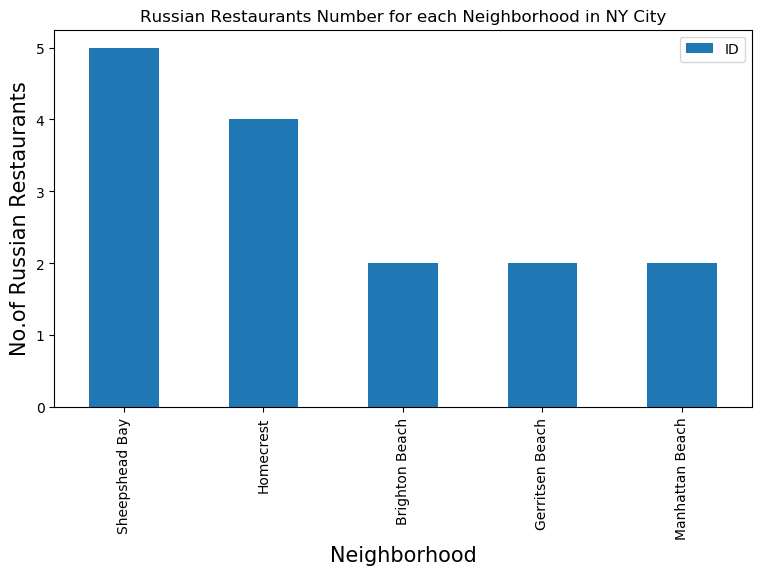

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Russian Restaurants Number for each Neighborhood in NY City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Russian Restaurants', fontsize=15)
#giving a bar plot
ru_restaurants_neighbor.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [17]:
ru_restaurants_neighbor[ru_restaurants_neighbor['Neighborhood']=='Sheepshead Bay']

,Borough,Neighborhood,ID,Name
3,Brooklyn,Sheepshead Bay,5a08f7e2d48ec1369706f57d,Bellarussian Xata
4,Brooklyn,Sheepshead Bay,55d6885e498e41b9e7b8b5e8,Cafe Dushanbe
5,Brooklyn,Sheepshead Bay,5324ee02498e9a825bb4f689,La Vue Restaurant
6,Brooklyn,Sheepshead Bay,4b2ecbf5f964a520cee624e3,Passage
7,Brooklyn,Sheepshead Bay,4b53cec1f964a520f9ab27e3,Vanka Vstanka


In [18]:
ru_restaurants_neighbor[ru_restaurants_neighbor['Neighborhood']=='Homecrest']

,Borough,Neighborhood,ID,Name
16,Brooklyn,Homecrest,4a2937fcf964a52069951fe3,Stolovaya
17,Brooklyn,Homecrest,45a5267bf964a520fc401fe3,Pirosmani
18,Brooklyn,Homecrest,52b4e4a5498e11c54d9fdb6d,Padishah
19,Brooklyn,Homecrest,5216b79a11d2f52ef2ee2e24,The Art House


### Let's rank the restaurants

In [19]:
# prepare neighborhood list that contains Russian Restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
ru_rstrnt_stat_neighbor=pd.DataFrame(columns=column_names)
count=1


for row in ru_restaurants_neighbor.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(ru_restaurants_neighbor),')','processed')
    ru_rstrnt_stat_neighbor = ru_rstrnt_stat_neighbor.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID       Name  Likes  Rating  Tips
0  4a2937fcf964a52069951fe3  Stolovaya     41     8.1    27
( 1 / 20 ) processed
                         ID        Name  Likes  Rating  Tips
0  4ac69109f964a52017b520e3  Skovorodka     95     8.1    48
( 2 / 20 ) processed
                         ID                Name  Likes  Rating  Tips
0  4245f780f964a52070201fe3  Tatiana Restaurant    158     6.8    67
( 3 / 20 ) processed
                         ID               Name  Likes  Rating  Tips
0  5a08f7e2d48ec1369706f57d  Bellarussian Xata     24     8.7     7
( 4 / 20 ) processed
                         ID           Name  Likes  Rating  Tips
0  55d6885e498e41b9e7b8b5e8  Cafe Dushanbe     10     7.4     3
( 5 / 20 ) processed
                         ID               Name  Likes  Rating  Tips
0  5324ee02498e9a825bb4f689  La Vue Restaurant     23     7.0     3
( 6 / 20 ) processed
                         ID     Name  Likes  Rating  Tips
0  4b2ecbf5f964a520cee624e3  Passage

In [20]:
ru_rstrnt_stat_neighbor.head()


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Gravesend,4a2937fcf964a52069951fe3,Stolovaya,41,8.1,27
1,Brooklyn,Brighton Beach,4ac69109f964a52017b520e3,Skovorodka,95,8.1,48
2,Brooklyn,Brighton Beach,4245f780f964a52070201fe3,Tatiana Restaurant,158,6.8,67
3,Brooklyn,Sheepshead Bay,5a08f7e2d48ec1369706f57d,Bellarussian Xata,24,8.7,7
4,Brooklyn,Sheepshead Bay,55d6885e498e41b9e7b8b5e8,Cafe Dushanbe,10,7.4,3


In [21]:
ru_restaurants_neighbor.shape

(20, 4)

Next step is to export data to csv

In [22]:
ru_rstrnt_stat_neighbor.to_csv('ru_rstrnt_stat_neighbor.csv', index= False)

In [23]:
ru_rstrnt_stat_neighbor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
Borough         20 non-null object
Neighborhood    20 non-null object
ID              20 non-null object
Name            20 non-null object
Likes           20 non-null object
Rating          20 non-null float64
Tips            20 non-null object
dtypes: float64(1), object(6)
memory usage: 1.2+ KB


In [24]:
ru_rstrnt_stat_neighbor['Likes']=ru_rstrnt_stat_neighbor['Likes'].astype('float64')

In [25]:
ru_rstrnt_stat_neighbor['Tips']=ru_rstrnt_stat_neighbor['Tips'].astype('float64')

In [26]:
ru_rstrnt_stat_neighbor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
Borough         20 non-null object
Neighborhood    20 non-null object
ID              20 non-null object
Name            20 non-null object
Likes           20 non-null float64
Rating          20 non-null float64
Tips            20 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.2+ KB


In [27]:
# Restaurant maximum Likes
ru_rstrnt_stat_neighbor.iloc[ru_rstrnt_stat_neighbor['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a777018f964a5207be41fe3
Name                          Mari Vanna
Likes                                546
Rating                                 9
Tips                                 193
Name: 14, dtype: object

In [28]:
# Restaurant maximum Rating
ru_rstrnt_stat_neighbor.iloc[ru_rstrnt_stat_neighbor['Rating'].idxmax()]


Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a777018f964a5207be41fe3
Name                          Mari Vanna
Likes                                546
Rating                                 9
Tips                                 193
Name: 14, dtype: object

In [29]:
# Restaurant maximum Tips
ru_rstrnt_stat_neighbor.iloc[ru_rstrnt_stat_neighbor['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a777018f964a5207be41fe3
Name                          Mari Vanna
Likes                                546
Rating                                 9
Tips                                 193
Name: 14, dtype: object

In [30]:
neighb_stats=ru_rstrnt_stat_neighbor.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
neighb_stats.columns=['Neighborhood','Average Rating']

In [31]:

print('Below are the top neighborhoods with top average rating Russian restaurants')
neighb_stats.sort_values(['Average Rating'],ascending=False).head(10)


Below are the top neighborhoods with top average rating Russian restaurants


,Neighborhood,Average Rating
1,Flatiron,9.000
3,Gramercy,9.000
4,Gravesend,8.100
7,Manhattan Terrace,7.800
8,Ocean Parkway,7.800
0,Brighton Beach,7.450
9,Sheepshead Bay,7.040
5,Homecrest,6.925
6,Manhattan Beach,6.750
2,Gerritsen Beach,6.500


In [32]:
borough_stats=ru_rstrnt_stat_neighbor.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
borough_stats.columns=['Borough','Average Rating']

In [33]:
borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,9.000000
0,Brooklyn,7.111111


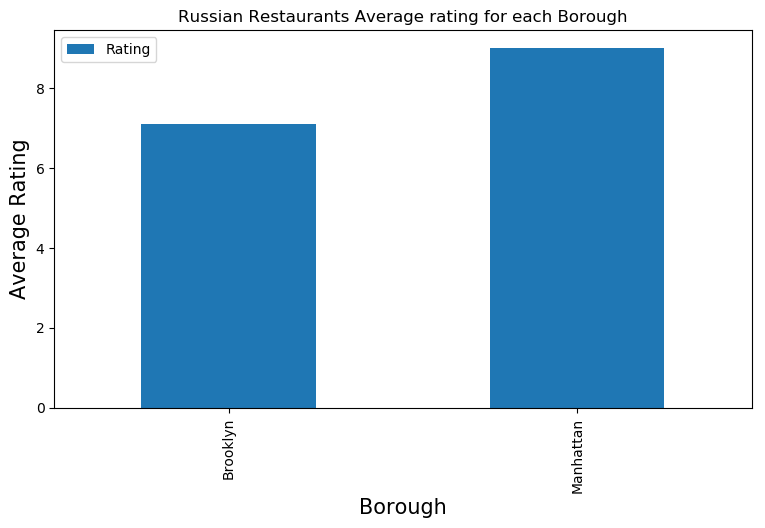

In [34]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Russian Restaurants Average rating for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
ru_rstrnt_stat_neighbor.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [35]:
neighb_stats=neighb_stats[neighb_stats['Average Rating']>=7.0]

In [36]:
neighb_stats

,Neighborhood,Average Rating
0,Brighton Beach,7.45
1,Flatiron,9.00
3,Gramercy,9.00
4,Gravesend,8.10
7,Manhattan Terrace,7.80
8,Ocean Parkway,7.80
9,Sheepshead Bay,7.04


Now we have to join this dataset to original new york data to get lonitude and latitude


In [37]:
neighb_stats=pd.merge(neighb_stats,new_york_data, on='Neighborhood')



In [38]:
neighb_stats=neighb_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
neighb_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Brighton Beach,40.576825,-73.965094,7.45
1,Manhattan,Flatiron,40.739673,-73.990947,9.00
2,Manhattan,Gramercy,40.737210,-73.981376,9.00
3,Brooklyn,Gravesend,40.595260,-73.973471,8.10
4,Brooklyn,Manhattan Terrace,40.614433,-73.957438,7.80
5,Brooklyn,Ocean Parkway,40.613060,-73.968367,7.80
6,Brooklyn,Sheepshead Bay,40.586890,-73.943186,7.04


### Map preps

In [39]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [44]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in neighb_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='green',
            fill_opacity=0.6
        )
    )



In [45]:
neighb_stats['Label']=neighb_stats['Neighborhood']+', '+neighb_stats['Borough']+'('+neighb_stats['Average Rating'].map(str)+')'


In [46]:

# add pop-up text to each marker on the map
for lat, lng, label in neighb_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

